*Берутся видео с датасета `https://disk.yandex.ru/d/_vjY_E84Bs1p-Q`, обрезается лишнее(чтобы не было очень сильного дисбаланса классов), бьются на кадры, затем вручную в csv файл записываются метки каждого кадра, а также координаты бокса с человеком(если вдруг понадобится)*
Получившийся датасет лежит в `https://drive.google.com/drive/folders/1YTx-Rj6D7dj0WFRjYTJHJ6_gOz8KsCh5`

*Обрезаем видео*

In [1]:
pip install --trusted-host pypi.python.org moviepy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imageio-ffmpeg

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
start_time = 20 # seconds
end_time = 26
ffmpeg_extract_subclip("Shoplifting1.mp4", start_time, end_time, targetname="test.mp4")

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [3]:
def video_cut(video, start_time, end_time, count): # save cut video in the same directory
    ffmpeg_extract_subclip(video, start_time, end_time, targetname="Shoplifting"+str(count)+".mp4")

In [41]:
video_cut("/home/anastasia/Downloads/Shoplifting053_x264.mp4", 40, 48, 48)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [4]:
from moviepy.editor import VideoFileClip, vfx

def speed_up_video(input_video_path):
    output_path = input_video_path.replace('.mp4', '_speed.mp4')  
    video = VideoFileClip(input_video_path)
    speedup_video = video.fx(vfx.speedx, 1.5)  
    speedup_video.write_videofile(output_path, codec='libx264') 

*Получаем кадры*

In [72]:
import cv2
import os
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from PIL import Image
def receive_frames(video_path, counter):
    #video_path = 'Shoplifting5.mp4' 
    output_folder = 'output_frames_1'
    
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    #counter = 5
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        frame_name = f'frame_{counter}_{frame_count}.jpg'
        cv2.imwrite(os.path.join(output_folder, frame_name), frame)
    
    cap.release()
    #cv2.destroyAllWindows()
    return

In [73]:
for i in range(23, 49):
    video_name = f"Shoplifting{i}.mp4"
    receive_frames(video_name, i)

In [42]:
import pandas as pd
df_frames = pd.DataFrame(columns = ['file_name', 'labels'])

In [21]:
import pandas as pd
df_frames = pd.read_csv('metadata.csv')

In [22]:
df_frames

,file_name,labels
0,frame_2_105.jpg,1
1,frame_7_484.jpg,1
2,frame_8_87.jpg,1
3,frame_7_112.jpg,0
4,frame_7_388.jpg,0
...,...,...
11975,frame_34_54.jpg,1
11976,frame_35_79.jpg,0
11977,frame_36_58.jpg,1
11978,frame_37_112.jpg,0


*Добавляем в датафрейм новые кадры*

In [74]:
import os
image_dir = 'output_frames_1'
image_files = os.listdir(image_dir)
new_rows = []
for image_file in image_files:
        file_name = os.path.basename(image_file)
        if file_name not in df_frames['file_name'].values:
            new_row = {'file_name': file_name, 'labels': 0}
            new_rows.append({'file_name': file_name, 'labels': 0})
df_frames = pd.concat([df_frames, pd.DataFrame(new_rows)], ignore_index=True)

In [75]:
df_frames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11980 entries, 0 to 11979
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  11980 non-null  object
 1   labels     11980 non-null  object
dtypes: object(2)
memory usage: 187.3+ KB


*Проставляем метки на кадры краж*

In [134]:
def set_label(number_video, start_frame, finish_frame):
    for i in range(start_frame, finish_frame + 1):
        df_frames.loc[df_frames['file_name'] == f"frame_{number_video}_{i}.jpg", 'labels'] = 1

In [209]:
set_label(48, 96, 131)

*Просмотров кадров*

In [181]:
import os
from PIL import Image
import time
def show_video_frames(number_video):
    path = 'frames'
    images = [img for img in os.listdir(path) if img.endswith(".jpg") and f"frame_{number_video}" in img]
    #images.sort()
    
    for img in images:
        image_path = os.path.join(path, img)
        image = Image.open(image_path)
        image.show()
        time.sleep(0.25)
        image.close()
    return

<Axes: ylabel='Frequency'>

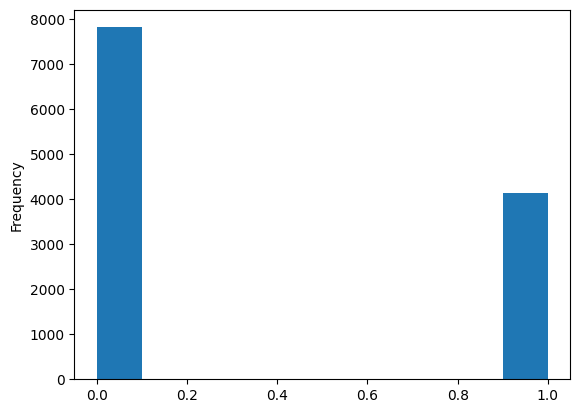

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
df_frames['labels'].plot(kind='hist')

In [211]:
(df_frames['labels'] == 1).sum()

4153

In [212]:
df_frames.to_csv('metadata.csv', index=False)

*Вспомогательные функции для обрезки по yolo боксам*

In [73]:
from PIL import Image

def crop_image(image, box):
    additional_area = 1/5
    x_min, y_min, x_max, y_max = box
    width, height = image.size
    box_width = x_max - x_min
    box_height = y_max - y_min
    x_min_2 = max(0, x_min - box_width*additional_area)
    y_min_2 = max(0, y_min - box_height*additional_area)
    x_max_2 = min(width, x_max + box_width*additional_area)
    y_max_2 = min(height, y_max + box_height*additional_area)
    area = (x_min_2, y_min_2, x_max_2, y_max_2)
    cropped_img = image.crop(area)
    return cropped_img

In [26]:
import os
def recieve_box(image, frame):
    model = YOLO('yolov8n.pt')
    model.classes = [0]
    results = model(source = image, classes=0, show = False, imgsz=640, conf=0.3, iou=0.4, save = False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
    cropped_images = []
    for box in boxes:
        cropped_images.append(crop_image(image, box))
    save_dir = 'frames_cropped'
    counter = 1
    for im in cropped_images:
        save_path = os.path.join(save_dir, f"_cropped_{counter}.jpg")
        im.save(save_path)
        counter+=1

In [28]:
path_to_image = 'frames/frame_30_106.jpg'
image = Image.open(path_to_image)
recieve_box(image, path_to_image)


0: 480x640 7 persons, 51.6ms
Speed: 12.1ms preprocess, 51.6ms inference, 8.7ms postprocess per image at shape (1, 3, 480, 640)


In [19]:
for im in res:
    im.show()

In [ ]:

from ultralytics.utils.plotting import Annotator

model = YOLO('yolov8n.pt')
model.classes = [0]
image_path = '/content/drive/MyDrive/yolo_dataset/test/images/cam-pos-video-five_0mABuXZe_mp4-36_jpg.rf.9f17c4aa766ded211ed3a70d1728403f.jpg'
results = model(source = image_path, classes=0, show = False, imgsz=640, conf=0.3, iou=0.4, save = True)

import os
image_path = '/content/drive/MyDrive/yolo_dataset/test/images/cam-pos-video-five_0mABuXZe_mp4-36_jpg.rf.9f17c4aa766ded211ed3a70d1728403f.jpg'
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
save_dir = 'runs/detect/predict18'
for box in boxes:
    x_min, y_min, x_max, y_max = box
    #print(f"Box coordinates: ({x_min}, {y_min}), ({x_max}, {y_max})")
    img = Image.open(image_path)
    width, height = img.size
    box_width = x_max - x_min
    box_height = y_max - y_min
    x_min_2 = max(0, x_min - box_width/3)
    y_min_2 = max(0, y_min - box_height/3)
    x_max_2 = min(width, x_max+ box_width/3)
    y_max_2 = min(height, y_max + box_height/3)
    area = (x_min_2, y_min_2, x_max_2, y_max_2)
    cropped_img = img.crop(area)
    save_path = os.path.join(save_dir, "cropped_.jpg")
    cropped_img.save(save_path)

*Функция для трекинга человека на видео. Сохраняет видео с людьми в боксах и помечает их id*

In [51]:
import cv2
from ultralytics import YOLO
from PIL import Image
def process_video_with_tracking(model, input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        raise Exception("Error: Could not open video file.")

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        results = model.track(frame, iou=0.4, conf=0.25, persist=True, imgsz=608, verbose=False, tracker="bytetrack.yaml", classes=0)
    
        if results[0].boxes.id != None: # this will ensure that id is not None -> exist tracks
            boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
            ids = results[0].boxes.id.cpu().numpy().astype(int)

            for box, id in zip(boxes, ids):
                additional_area = 1/10
                x_min, y_min, x_max, y_max = box
                width, height = frame_width, frame_height
                box_width = x_max - x_min
                box_height = y_max - y_min
                x_min_2 = max(0, x_min - box_width*additional_area)
                y_min_2 = max(0, y_min - box_height*additional_area)
                x_max_2 = min(width, x_max + box_width*additional_area)
                y_max_2 = min(height, y_max + box_height*additional_area)
                area = (x_min_2, y_min_2, x_max_2, y_max_2)
                cropped_img = Image.fromarray(frame, 'RGB').crop(area)
                cropped_frame = frame[box[1]:box[3], box[0]:box[2]]
                color = (0, 255, 255)
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3],), color, 2)
                cv2.putText(
                    frame,
                    f"Id {id}",
                    (box[0], box[1]),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.70,
                    (0, 255, 255),
                    2,
                )

        
        out.write(frame)

    cap.release()
    out.release()

    return results

*Функция, которая получает видео с n людьми в кадре и записывает в директорию n видео, где k-ое видео представляет собой исходное, обрезанное так, чтобы в кадре был только k-ый человек*

In [23]:
import cv2
from ultralytics import YOLO
import numpy as np

def process_video_individual_padding(model, input_video_path, output_dir):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise Exception("Error: Could not open video file.")

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    writers = {}
    writers_sizes = {}
    frame_count = 0
    additional_area = 1/5

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, iou=0.4, conf=0.3, persist=True, imgsz=608, verbose=False, tracker="bytetrack.yaml", classes=0)
        frame_count += 1

        if hasattr(results[0].boxes, 'id') and results[0].boxes.id is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
            ids = results[0].boxes.id.cpu().numpy().astype(int)

            for box, person_id in zip(boxes, ids):
                x_min, y_min, x_max, y_max = box
                pad_width = (x_max - x_min) * additional_area
                pad_height = (y_max - y_min) * additional_area
                x_min_pad = max(0, int(x_min - pad_width))
                y_min_pad = max(0, int(y_min - pad_height))
                x_max_pad = min(frame_width, int(x_max + pad_width))
                y_max_pad = min(frame_height, int(y_max + pad_height))

                cropped_frame = frame[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                if person_id not in writers:
                    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                    output_size = (x_max_pad - x_min_pad, y_max_pad - y_min_pad)
                    writer = cv2.VideoWriter(f"{output_dir}/person_{person_id}.mp4", fourcc, fps, output_size)
                    writers[person_id] = writer
                    writers_sizes[person_id] = output_size
                    
                else:
                    desired_size = writers_sizes[person_id]
                    resized_frame = cv2.resize(cropped_frame, desired_size)

                    if resized_frame.size != 0:
                        writers[person_id].write(resized_frame)

        if frame_count % 100 == 0:
            print(f"Processed {frame_count} frames.")


    cap.release()
    for writer in writers.values():
        writer.release()

    writers.clear()
    writers_sizes.clear()
    return

*Обрезаем видео по конкретному боксу(человека с id=track_id)*

In [44]:
import cv2
from ultralytics import YOLO

def process_single_track_video(model, input_video_path, output_video_path, track_id):
    
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise Exception("Error: Could not open video file.")
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    out = None
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, iou=0.4, conf=0.3, persist=True, imgsz=608, verbose=False, tracker="bytetrack.yaml", classes=0)
        
        if hasattr(results[0].boxes, 'id') and results[0].boxes.id != None:
            boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
            ids = results[0].boxes.id.cpu().numpy().astype(int)

            for box, id in zip(boxes, ids):
                if id == track_id:
                    x_min, y_min, x_max, y_max = box
                    if out is None:
                        width = x_max - x_min
                        height = y_max - y_min
                        if width > 0 and height > 0:
                            out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
                            fixed_size = (int(width), int(height))
                    try:
                        x_min = max(x_min, 0)
                        y_min = max(y_min, 0)
                        x_max = min(frame_width, x_max)
                        y_max = min(frame_height, y_max)
                        cropped_frame = frame[y_min:y_max, x_min:x_max]
                        if cropped_frame.shape[1] != fixed_size[0] or cropped_frame.shape[0] != fixed_size[1]:
                            cropped_frame = cv2.resize(cropped_frame, (fixed_size[0], fixed_size[1]))
                        out.write(cropped_frame)
                    except Exception as e:
                        print("Error managing frame size:", e)
    
    cap.release()
    if out is not None:
        out.release()

*examples of usages*

In [20]:
model = YOLO('yolov8m.pt')
model.fuse()
results = process_video_individual_padding(model, "Shoplifting1.mp4", output_dir="output")

YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs
Processed 100 frames.


In [50]:
model = YOLO('yolov8n.pt')
model.fuse()
results = process_video_with_tracking(model, "Shoplifting7.mp4", output_video_path="output/output_sample7.mp4")

YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


In [53]:
model = YOLO('yolov8m.pt')
model.fuse()
process_single_track_video(model, "videos_with_boxes/focused_Shoplifting6.mp4", "output_sample6.mp4", 28)

YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs


In [35]:

process_single_track_video(model, "Shoplifting46.mp4", "output_sample46.mp4", 1)

In [32]:
pwd

'/home/anastasia/Desktop/project_dataset'

In [48]:
cwd = os.getcwd()

'/home/anastasia/Desktop/project_dataset'

In [49]:
import os
def process_all_videos(directory_path, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    model = YOLO('yolov8m.pt')
    model.fuse()
    for i in range(2, 49):
        if i not in [42, 43, 44, 45]:
            video_filename = f"Shoplifting{i}.mp4"
            video_path = os.path.join(directory_path, video_filename)
            if os.path.exists(video_path):
                output_video_path = os.path.join(output_directory, f"focused_{video_filename}")
                print(f"Processing video: {video_filename}")
                try:
                    process_video_with_tracking(model, video_path, output_video_path)
                except Exception as e:
                    print(f"Failed to process {video_filename}: {str(e)}")
            else:
                print(f"File {video_filename} does not exist in the directory")
    
src_directory = cwd
res_directory = "videos_with_boxes"

process_all_videos(src_directory, res_directory)

YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs
Processing video: Shoplifting2.mp4
Processing video: Shoplifting3.mp4
Processing video: Shoplifting4.mp4
Processing video: Shoplifting5.mp4
Processing video: Shoplifting6.mp4
Processing video: Shoplifting7.mp4


KeyboardInterrupt: 